<h1 style="text-align: center;">Semantic Segmentation - Neural Network</h1>
<h3 style="text-align: center;">Carlos Moreno</h3>

In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

from PIL import Image
import numpy as np
import glob
import cv2
import pickle

Run device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4070 SUPER


->Load Dataset

In [3]:

def Set_tif_Dataset(path, width= 256, height= 256):
    images_list = []

    with Image.open(path) as img:
        try:
            while True:
                # Convert each page to an RGB image
                img_rgb = img.convert("L")

                # Resize to the desired dimensions
                img_resized = img_rgb.resize((width, height))

                # Convert to a NumPy array and normalize pixel values to [0, 255]
                img_array = np.array(img_resized)/255.0

                # Add to the list
                images_list.append(img_array)

                # Move to the next page
                img.seek(img.tell() + 1)
        except EOFError:
            pass  # End of the TIFF file
    return np.stack(images_list[:200])

In [4]:
train_ds = Set_tif_Dataset('..\\Database\\EPFL\\training.tif')
train_mask_ds = Set_tif_Dataset('..\\Database\\EPFL\\training_groundtruth.tif')

test_ds = Set_tif_Dataset('..\\Database\\EPFL\\testing.tif')
test_mask_ds = Set_tif_Dataset('..\\Database\\EPFL\\testing_groundtruth.tif')

In [5]:
train_ds.shape

(165, 256, 256)

In [6]:
class MainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (H, W, C) -> (C, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return image, mask

In [7]:
train_dataset = MainDataset(train_ds, train_mask_ds)
test_dataset = MainDataset(test_ds, test_mask_ds)

train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True) 
test_dl =  DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True) 

In [8]:
class FConvNet(nn.Module):
    def __init__(self, num_classes=2, input_size=(256,256)):  
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=num_classes, kernel_size=1)  # Final convolutional layer
        self.upsample = nn.Upsample(size=input_size, mode='bilinear', align_corners=False)  # Upsample to input size
        self.R = nn.ReLU()

    def forward(self, x):
        x = self.R(self.conv1(x))
        x = self.pool(x)
        x = self.R(self.conv2(x))
        x = self.pool(x)
        x = self.conv3(x)  # Apply 1x1 convolution to produce class scores
        x = self.upsample(x)  # Upsample to match input resolution
        return x

In [9]:
def CheckAccuracy(loader, model, name, device='cuda'):
    dice_scores = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).squeeze(1)  # Remove channel dimension

            # Model prediction
            y_hat = model(x)
            y_hat = torch.argmax(y_hat, dim=1)  # Convert logits to class labels

            # Calculate Dice Score
            intersection = (y_hat * y).sum(dim=(1, 2))
            union = y_hat.sum(dim=(1, 2)) + y.sum(dim=(1, 2))
            dice = (2.0 * intersection) / (union )  # Add epsilon to avoid division by zero
            dice_scores.append(dice.mean().item())

    #print(f"Dice Score of {name}: {dice.mean():.4f}")
    model.train()
    return dice_scores

## Optimización

In [15]:
def train_model(dl, model, n_epochs=20, device='cuda'):
    # Optimization
    opt = Adam(model.parameters(), lr=3e-4)  # karpathy's constant
    criterion = nn.CrossEntropyLoss()  # Binary cross-entropy loss with logits

    # Initialize progress bar and timing
    start_time = time.time()
    total_steps = n_epochs * len(dl)

    # Train model
    losses = []
    epochs = []
    accuracy = []

    with tqdm(total=total_steps, desc="Training Progress", dynamic_ncols=True, leave=True) as pbar:
        for epoch in range(n_epochs):
            model.train()
            N = len(dl)

            for i, (x, y) in enumerate(dl):
                x, y = x.to(device), y.to(device).squeeze(1).long()  # Convert mask to [B, H, W] and integer type
                opt.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                opt.step()

                # Store training data
                epochs.append(epoch + i / N)
                losses.append(loss.item())

                # Update progress bar
                pbar.update(1)

            # Calculate time left
            elapsed_time = time.time() - start_time
            remaining_steps = total_steps - pbar.n
            time_per_step = elapsed_time / pbar.n if pbar.n > 0 else 0
            estimated_time_left = time_per_step * remaining_steps
            
            accuracy.append(CheckAccuracy(train_dl, model, "Train Data", device=device))

            # Set progress bar postfix with estimated time left
            pbar.set_postfix({
                "Epoch": f"{epoch + 1}/{n_epochs}",
                "Last Batch Loss": f"{loss.item():.4f}",
                "Accurasy": f"{accuracy[-1][-1]}",
                "Estimated Time Left": f"{int(estimated_time_left // 60)}m {int(estimated_time_left % 60)}s"
            })

    return np.array(epochs), np.array(losses), accuracy

In [11]:
class Report:
    def __init__(self, epoch, loss, Accuracy, type = "Training", n_epochs=20):
        self.epoch = epoch
        self.loss = loss
        self.type = type
        self.n_epochs = n_epochs
        self.Accuracy = Accuracy
        self.epoch_data_avgd = self.epoch.reshape(self.n_epochs,-1).mean(axis=1)
        self.loss_data_avgd = self.loss.reshape(self.n_epochs,-1).mean(axis=1)
    
    def plot_training(self):
        plt.figure(figsize=(5,4))
        plt.plot(self.epoch_data_avgd, self.loss_data_avgd, 'o--', label='Loss', color="Cyan")
        plt.xlabel('Epoch Number')
        plt.ylabel('Cross Entropy')
        plt.title(f'Cross Entropy (avgd per epoch) - {self.type}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        plt.figure(figsize=(5, 4))
        plt.plot([i for i in range(1, self.n_epochs + 1)], self.Accuracy, 'd--', label='Accuracy', color='orange')
        plt.xlabel('Epoch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(min(self.Accuracy)*0.9, 100)
        plt.xlim(0, self.n_epochs)
        plt.title(f'Accuracy Over Epochs - {self.type}')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [16]:
torch.cuda.empty_cache()
model = FConvNet(num_classes=2).to('cuda')
epoch_data, loss_data, Accurasy_data = train_model(train_dl, model, n_epochs=200, device='cuda')

Training Progress: 100%|██████████| 4200/4200 [00:39<00:00, 105.36it/s, Epoch=200/200, Last Batch Loss=0.0642, Accurasy=0.4240771234035492, Estimated Time Left=0m 0s]  


In [13]:
Accurasy_data

[[0.12035413086414337,
  0.09722711145877838,
  0.09793423116207123,
  0.08057047426700592,
  0.09721259772777557,
  0.10320112109184265,
  0.11157524585723877,
  0.10187441855669022,
  0.09641075879335403,
  0.10325758904218674,
  0.09922704100608826,
  0.10938186943531036,
  0.09043820202350616,
  0.12764295935630798,
  0.12449454516172409,
  0.114759162068367,
  0.12642140686511993,
  0.10885584354400635,
  0.13452330231666565,
  0.090548574924469,
  0.07934445142745972],
 [0.11479968577623367,
  0.10941888391971588,
  0.08720703423023224,
  0.13160523772239685,
  0.09631691873073578,
  0.12112480401992798,
  0.0909920185804367,
  0.09576490521430969,
  0.10927275568246841,
  0.10183915495872498,
  0.09866231679916382,
  0.13172274827957153,
  0.09557884186506271,
  0.07574407756328583,
  0.10313412547111511,
  0.10476666688919067,
  0.12728163599967957,
  0.09768505394458771,
  0.10888612270355225,
  0.10092022269964218,
  0.13244430720806122],
 [0.4591268301010132,
  0.47642838954

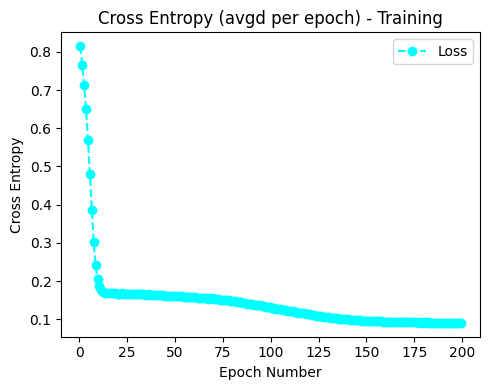

TypeError: can't multiply sequence by non-int of type 'float'

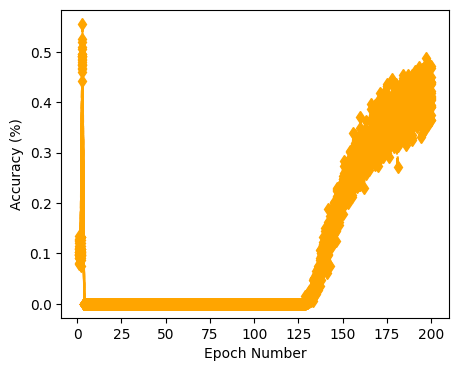

In [14]:
Analisis = Report(epoch_data, loss_data, Accurasy_data,  n_epochs =200)
Analisis.plot_training(), Analisis.plot_accuracy()

In [33]:
acurracy = CheckAccuracy(test_dl, model, "Test Data")
acurracy[-1]

0.41979679465293884

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(1, 100):
    plt.subplot(10, 10, i)
    
    # Move the tensor to CPU and convert it to NumPy for visualization
    
    plt.imshow(train_ds[i], cmap="gray")
    plt.axis("off")
    
fig.tight_layout()
plt.show()

In [34]:
def plot_predictions(model, loader, device='cuda'):
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).squeeze(1)  # Remove channel dimension

            # Model prediction
            y_hat = model(x)
            y_hat = torch.argmax(y_hat, dim=1).cpu().numpy()  # Convert logits to class labels

            # Plot the first sample in the batch
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
            axes[0].set_title("Input Image")

            axes[1].imshow(y[0].cpu().numpy(), cmap='gray')
            axes[1].set_title("Ground Truth Mask")

            axes[2].imshow(y_hat[0], cmap='gray')
            axes[2].set_title("Predicted Mask")

            plt.show()
            

In [45]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import torch

def plot_predictions_interactive(model, loader, device='cuda'):
    model.eval()
    inputs, ground_truths, predictions = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).squeeze(1)  # Remove channel dimension

            # Model prediction
            y_hat = model(x)
            y_hat = torch.argmax(y_hat, dim=1).cpu().numpy()  # Convert logits to class labels

            # Store data for visualization
            inputs.extend(x[:, 0].cpu().numpy())
            ground_truths.extend(y.cpu().numpy())
            predictions.extend(y_hat)

    def show_sample(idx):
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))

        axes[0].imshow(inputs[idx], cmap='gray')
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        axes[1].imshow(ground_truths[idx], cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(predictions[idx], cmap='gray')
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        plt.show()

    # Create interactive slider
    interact(show_sample, idx=(0, len(inputs) - 1))

# Example usage:
# plot_predictions_interactive(your_model, your_loader, device='cuda')


In [46]:
plot_predictions_interactive(model, test_dl)

interactive(children=(IntSlider(value=82, description='idx', max=164), Output()), _dom_classes=('widget-intera…